In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

In [2]:
class Mixture(nn.Module):
    def __init__(self):
        super().__init__()
        self.weight = nn.Parameter(torch.tensor([0.8, 0.2]), requires_grad=False)
        self.mean1 = nn.Parameter(torch.tensor([5., 5.]), requires_grad=False)
        self.mean2 = nn.Parameter(torch.tensor([-5., -5.]), requires_grad=False)
        self.covar = nn.Parameter(torch.eye(2), requires_grad=False)

    def init_prob(self):
        self.n1 = torch.distributions.MultivariateNormal(self.mean1, 1 * self.covar)
        self.n2 = torch.distributions.MultivariateNormal(self.mean2, 1 * self.covar)

    def sample(self, num_samples):
        choice = torch.multinomial(self.weight, num_samples, replacement=True)
        return torch.cat([self.n2.rsample([choice.sum()]), self.n1.rsample([num_samples - choice.sum()])])

    def likelihood(self, samples, log = True):
        n1_prob = torch.exp(self.n1.log_prob(samples))
        n2_prob = torch.exp(self.n2.log_prob(samples))
        prob = n1_prob * self.weight[0] + n2_prob * self.weight[1]
        if log:
            prob = torch.log(prob)
        return prob


In [3]:
mix  = Mixture()
mix.init_prob()

In [22]:
samples = mix.sample(1000)

Target distribution

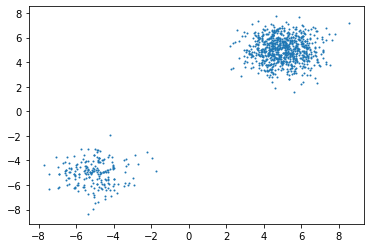

In [23]:
plt.scatter(*zip(*samples.numpy()), s = 1)
plt.show()

In [4]:
def Langevin_dynamics(prob, n_steps, s = None, step_size = 1e-1):
    
    arr = torch.empty(n_steps , 2)
    s = torch.rand(2, requires_grad=True) * 2 - 1 if s is None else s
    arr[0] = s
    for i in range(n_steps):
        s_prob = prob.likelihood(s)
        grad = torch.autograd.grad(s_prob, s)[0]
        noise = torch.randn_like(s) * np.sqrt(2 * step_size)
        s = s + step_size * grad + noise
        arr[i] = s
    return arr.cpu().detach().numpy()


Bad case: SGLD does not take into account relative weights<br>
1000 initial samples drawn from uniform $[-1, 1]$

In [16]:
arr = []
mix.init_prob()
for i in range(1000):
    samples = Langevin_dynamics(mix, 100)
    arr.append(samples[-1])
arr = np.stack(arr)

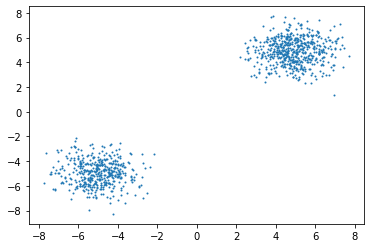

In [17]:
plt.scatter(*zip(*arr), s=1)
plt.show()